## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [41]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [43]:
# приведение столбца date к типу данных datetime
data['date'] = pd.to_datetime(data['date'], dayfirst=False)

# группировка данных по признаку группы 
daily_data = data.groupby('group')['date'].agg(['min', 'max']).reset_index()

daily_data

,group,min,max
0,A,2021-01-02,2021-01-24
1,B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [44]:
# количество посещений сайта в группах А и B
visit_a = data[data['group'] == 'A']['user_id'].count()
visit_b = data[data['group'] == 'B']['user_id'].count()

print(visit_a, visit_b)

147202 147276


In [45]:
data.groupby('group')['user_id'].agg('count')

group
A    147202
B    147276
Name: user_id, dtype: int64

In [46]:
# суммарное количество покупок в группах А и B
purchase_a = data[data['group'] == 'A']['purchase'].sum()
purchase_b = data[data['group'] == 'B']['purchase'].sum()

print(purchase_a, purchase_b)

17723 17514


In [47]:
data.groupby('group')['purchase'].sum()

group
A    17723
B    17514
Name: purchase, dtype: int64

In [48]:
# сумма всех покупок в группах А и B
price_a = data[data['group'] == 'A']['price'].sum() / 1000000
price_b = data[data['group'] == 'B']['price'].sum() / 1000000

print(price_a, price_b)

1436.26 1554.1


In [49]:
data.groupby('group')['price'].sum() / 1e6

group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [50]:
# создание множеств пользователей групп A и B
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

# пересечение множеств
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))

print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [51]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

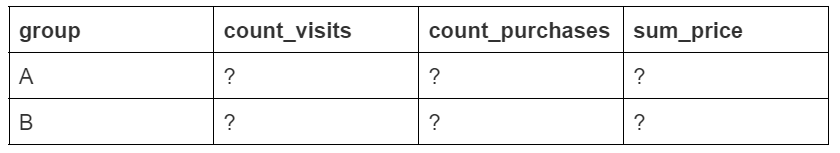
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [52]:
# группировка таблицы по признаку группы
grouped_data = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}).reset_index()

grouped_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Считаю, что выборки сбаланисированы, поскольку количество посещений обоих вариантов посадочной страницы сопоставимо (разница посещаемости составляет порядка 0.05% от количества посещений в группе (любой), что является незначительной величиной).

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [53]:
# добавление признаков conversion и mean_check
grouped_data['conversion'] = grouped_data['count_purchases'] / grouped_data['count_visits'] * 100
grouped_data['mean_check'] = grouped_data['sum_price'] / grouped_data['count_purchases']

In [54]:
# конверсия в группах
conv_a = round(grouped_data.loc[0, 'conversion'], 2)
conv_b = round(grouped_data.loc[1, 'conversion'], 2)

print(conv_a, conv_b)

12.03 11.89


In [55]:
# средний чек в группах
check_a = round(grouped_data.loc[0, 'mean_check'])
check_b = round(grouped_data.loc[1, 'mean_check'])

print(check_a, check_b)

81076 88665


In [56]:
print('Конверсия (в процентах) в группах А и B:')
display(grouped_data['conversion'].round(2))
print('\nСредний чек (в рублях) в группах А и B:')
display(grouped_data['mean_check'].round())

Конверсия (в процентах) в группах А и B:


0    12.03
1    11.89
Name: conversion, dtype: float64


Средний чек (в рублях) в группах А и B:


0    81076.0
1    88665.0
Name: mean_check, dtype: float64

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вариант А эффективнее варианта В по метрике конверсии (12.03% против 11.89%), при этом вариант В эффективнее варианта А по метрике среднего чека (81.1 тыс. руб. против 88.7 тыс. руб.).

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

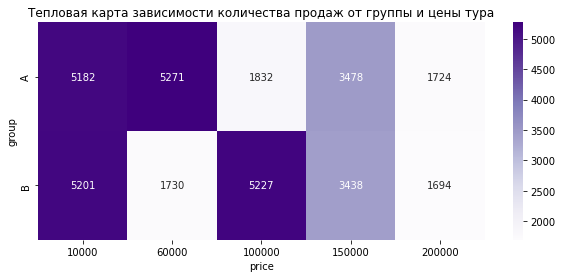

In [57]:
# создание сводной таблицы зависимости количества продаж от группы и цены тура
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    values='purchase',
    index='group', 
    columns='price', 
    aggfunc='sum'
)

fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='Purples');
ax.set_title('Тепловая карта зависимости количества продаж от группы и цены тура');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

В целом в группе А покупательская способность выше (в 3 направлениях из 5). Участники этой группы чаще участников группы В приобретают туры в Турцию и на Мальдивы.    
Участники группы В чаще приобретают туры в С-Пб и в Таиланд.    
Необходимо при этом отметить, что количество покупок туров на Камчатку в группах А и В сопоставимо - разница в 30 случаев несущественна.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [58]:
# группировка таблицы по дате и группе
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'users_count',
    'purchase': 'purchase_count',
    'price': 'sum_price'    
})

daily_data['conversion'] = daily_data['purchase_count'] / daily_data['users_count'] * 100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['purchase_count']

In [59]:
# конверсия 3 января 2021 года
# daily_data['date'] = pd.to_datetime(daily_data['date'], dayfirst=False)

conv_a = daily_data[(daily_data['group'] == 'A') & (daily_data['date'] == '2021-01-03')]['conversion']
conv_b = daily_data[(daily_data['group'] == 'B') & (daily_data['date'] == '2021-01-03')]['conversion']

print(round(conv_a, 2))
print(round(conv_b, 2))

2    11.34
Name: conversion, dtype: float64
3    11.39
Name: conversion, dtype: float64


In [79]:
daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2)

,group,conversion
2,A,11.34
3,B,11.39


In [60]:
# средний чек 3 января 2021 года
check_a = daily_data[(daily_data['group'] == 'A') & (daily_data['date'] == '2021-01-03')]['mean_check']
check_b = daily_data[(daily_data['group'] == 'B') & (daily_data['date'] == '2021-01-03')]['mean_check']

print(round(check_a))
print(round(check_b))

2    82888.0
Name: mean_check, dtype: float64
3    87480.0
Name: mean_check, dtype: float64


In [80]:
daily_data[daily_data['date'] == '2021-01-03'][['group', 'mean_check']].round()

,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [61]:
# добавление в таблицу кумулятивных признаков
daily_data['cum_users_count'] = daily_data.groupby('group')['users_count'].cumsum()
daily_data['cum_purch_count'] = daily_data.groupby(['group'])['purchase_count'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()

daily_data['cum_conv'] = daily_data['cum_purch_count'] / daily_data['cum_users_count'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_purch_count']

In [62]:
# кумулятивная конверсия в группе B 20 января 2021 года
daily_data[(daily_data['group'] == 'B') & (daily_data['date'] == '2021-01-20')]['cum_conv'].round(2)

37    11.9
Name: cum_conv, dtype: float64

In [81]:
daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conv']].round(2)

,group,cum_conv
36,A,11.98
37,B,11.90


In [63]:
# кумулятивный средний чек в группе А 12 января 2021 года
daily_data[(daily_data['group'] == 'A') & (daily_data['date'] == '2021-01-12')]['cum_mean_check'].round()

20    81492.0
Name: cum_mean_check, dtype: float64

In [82]:
daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round()

,group,cum_mean_check
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

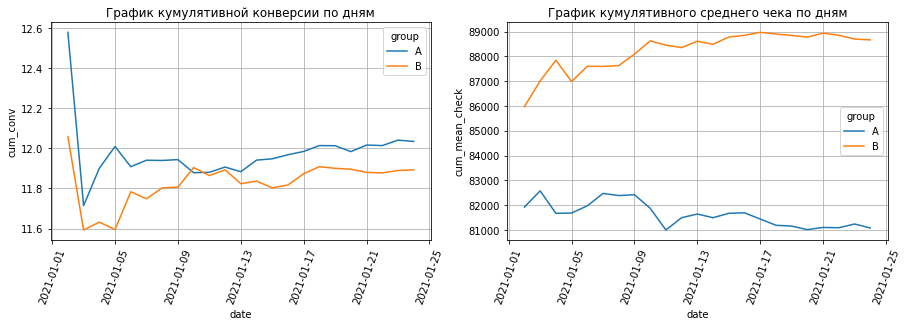

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
# построение lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data, 
    x='date', 
    y='cum_conv', 
    hue='group', 
    ax=axes[0]
)
axes[0].set_title('График кумулятивной конверсии по дням')
axes[0].xaxis.set_tick_params(rotation = 70)
axes[0].grid(True)

# построение lineplot для кумулятивного среднего чека в каждой группе
sns.lineplot(
    data=daily_data, 
    x='date', 
    y='cum_mean_check', 
    hue='group', 
    ax=axes[1]
)
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[1].xaxis.set_tick_params(rotation = 70)
axes[1].grid(True);

По результатам анализа графиков кумулятивных конверсии и среднего чека можно сделать вывод о том, что A/B-тестирование можно считать завершенным, поскольку значения рассматриваемых метрик стабилизировались во времени: кумулятивная конверсия в обеих группах стабилизировалась примерно после 13.01.2021, кумулятивный средний чек (для обеих групп) - примерно 11.01.2021.    
Необходимо также отметить, что кумулятивная конверсия группы А стабильно выше конверсии группы В на всем протяжении проведения теста (за единичным исключением 10.01.2021), при этом кумулятивный средний чек группы В значительно превышает средний чек группы А на всем протяжении проведении теста и имеет тенденцию к росту, когда как средний чек группы А имеет тенденцию к падению.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [65]:
# оценка количества успехов и размера выборки по группам
z_test_data = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
).reset_index()

In [66]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'

# уровень значимости
alpha = 0.05

# оценка p-value 
_, p_value = proportions_ztest(
    count = z_test_data['sum'],
    nobs=z_test_data['count'],
    alternative='larger'
)

if p_value < alpha:
    print(f'p-value: {round(p_value, 2)}. => Отвергаем нулевую гипотезу: {H0}')
    print(f'Альтернативная гипотеза: {H1}')
else:
    print(f'p-value: {round(p_value, 2)}. => Принимаем нулевую гипотезу: {H0}')

p-value: 0.12. => Принимаем нулевую гипотезу: Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

В связи с тем, что p-value теста (12%) выше уровня значимости (5%), результаты теста считаются статистически незначимыми, следовательно, нельзя отвергнуть нулевую гипотезу. Т.о. конверсии в группах А и В равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [67]:
# функция для определения доверительного интервала для конверсий
def proportions_conf_interval(n, x_p, gamma=0.95): # n - размер выборки, x_p - выборочная пропорция, gamma - уровень надёжности   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [68]:
# "разделение" датасета по группам
a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

In [69]:
# доверительный интервал для конверсии в группе А
conf_interval_a = proportions_conf_interval(
    a_data['user_id'].count(),
    a_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)


In [70]:
# доверительный интервал для конверсии в группе B
conf_interval_b = proportions_conf_interval(
    b_data['user_id'].count(),
    b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [71]:
# функция для определения доверительного интервала для разницы конверсий
def diff_proportions_conf_interval(n, xp, gamma=0.95): # n — список из размеров выборки для гр. А и B соотв., xp — список из выб. проп. для гр. А и B соотв., gamma — уровень надёжности
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [72]:
n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

С надежностью 95% конверсия группы А находится в интервале 11.87% - 12.20%, группы В - 11.73% - 12.06%.     
Наблюдается пересечение доверительных интервалов для конверсий групп А и В: от 11.87% до 12.06%, что может означать возможное совпадение истинного значения конверсии в обеих группах. Т.о. по результатам данного расчета однозначно сказать о наличии разницы в конверсиях не представляется возможным.    
Построение доверительного интервала для разницы конверсий подтверждает утверждение о том, что конверсии в группах А и В равны: нижняя граница интервала - отрицательная (-0.38%), верхняя граница интервала - положительная (0.09%).

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [73]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

# уровень значимости
alpha = 0.05 

# "разделение" датасета по группам
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])

print(f'p-value группы А: {round(shapiro_result_a.pvalue, 2)}')
print(f'p-value группы B: {round(shapiro_result_b.pvalue, 2)}')

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0}')
    print(f'Альтернативная гипотеза: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

p-value группы А: 0.25
p-value группы B: 0.09
Принимаем нулевую гипотезу: Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [74]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'

#уровень значимости
alpha = 0.05 

#вычисляем результат T-теста для выборок
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'], 
    alternative='less'
)

if results.pvalue < alpha:
    print(f'p-value: {round(results.pvalue, 2)}. => Отвергаем нулевую гипотезу: {H0}.')
    print(f'Альтернативная гипотеза: {H1}')
else:
    print(f'p-value: {round(results.pvalue, 2)}. => Принимаем нулевую гипотезу: {H0}')

p-value: 0.0. => Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны.
Альтернативная гипотеза: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

В связи с тем, что p-value теста ниже уровня значимости, результаты теста считаются статистически значимыми. Т.о. принимается альтернативная гипотеза о неравенстве средних чеков в группах (чек в группе А меньше среднего чека в группе В).

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [75]:
# функция для определения доверительного интервала
def conf_interval(n, x_mean, x_std, gamma=0.95): # n - размер выборки, x_mean - выборочное среднее, x_std - выборочное std, gamma - уровень надёжности
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
        
    return round(lower_bound), round(upper_bound)

In [76]:
# доверительный интервал для конверсии в группе А
conf_int_a = conf_interval(
    daily_data_a['users_count'].count(),
    daily_data_a['mean_check'].mean(),
    daily_data_a['mean_check'].std()
)

print(f'Доверительный интервал для среднего чека в группе А: {conf_int_a}')

Доверительный интервал для среднего чека в группе А: (79630, 82308)


In [77]:
# доверительный интервал для конверсии в группе B
conf_int_b = conf_interval(
    daily_data_b['users_count'].count(),
    daily_data_b['mean_check'].mean(),
    daily_data_b['mean_check'].std()
)

print(f'Доверительный интервал для среднего чека в группе B: {conf_int_b}')

Доверительный интервал для среднего чека в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

С надежностью 95% средний чек группы А находится в интервале 79.6 - 82.3 тыс. руб., в группе В - 87.6 - 89.5 тыс. руб., что однозначно выше (даже по нижней границе чека в группе В). Т.о. пересечения доверительных интервалов для рассматриваемой метрики нет.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По результатам проведения статистических тестов на сравнение выборок и расчетов доверительных интервалов можно сделать вывод, что предлагаемый к внедрению проект посадочной страницы официального сайта компании (тестовый вариант) является более предпочтительным: средний чек в группе В однозначно выше аналогичной метрики в группе А. При этом по метрике конверсии сделать вывод об оптимальном с точки зрения роста продаж варианте посадочной страницы не представляется возможным: метрики в группах равны.